<a href="https://colab.research.google.com/github/Ekliipce/Representation-and-Generative-Learning/blob/main/Variationnal_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Auto-encodeurs variationnels

Le but de ce notebook est d'entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)  # Moyenne mu
        self.fc22 = nn.Linear(400, 50)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
for epoch in range(10):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

100%|██████████| 9912422/9912422 [00:00<00:00, 86734964.27it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31357932.65it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19641113.50it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13784753.09it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Epoch 0, Loss: 168.7901486653646
Epoch 1, Loss: 126.3508955891927
Epoch 2, Loss: 117.18330185546876
Epoch 3, Loss: 112.87289838867187
Epoch 4, Loss: 110.46492711588542
Epoch 5, Loss: 108.97699886067709
Epoch 6, Loss: 107.94992978515624
Epoch 7, Loss: 107.18701930338541
Epoch 8, Loss: 106.63427600911459
Epoch 9, Loss: 106.14623102213541


## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Encode image and decode

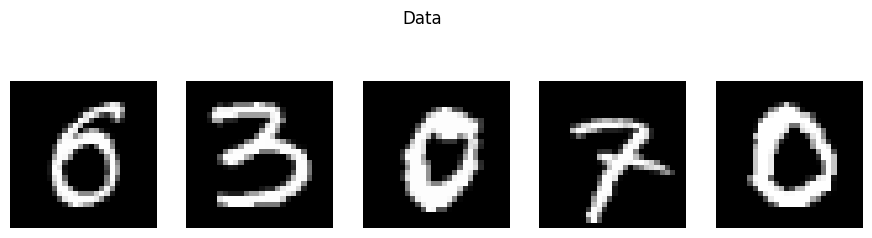

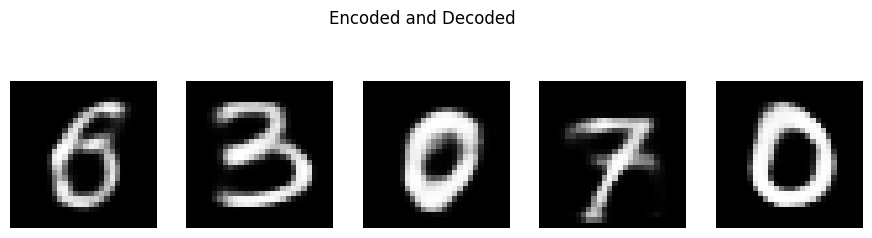

In [ ]:
import PIL
import matplotlib.pyplot as plt

for batch in train_loader:
    lot_item = batch[0]
    break

samples = 5

plt.figure(figsize=(11, 3))
plt.suptitle("Data")
for i in range(1, samples + 1):
  plt.subplot(1, 5, i)
  plt.imshow(lot_item[i].permute(1, 2, 0), cmap="gray")
  plt.axis("off")
plt.show()

plt.figure(figsize=(11, 3))
plt.suptitle("Encoded and Decoded")
for i in range(1, samples + 1):
    flat_image = lot_item[i].view(-1, 784)
    decoded = vae.forward(flat_image)[0]

    plt.subplot(1, 5, i)
    plt.imshow(decoded.view(28, 28).detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

### Decoded Images from Random

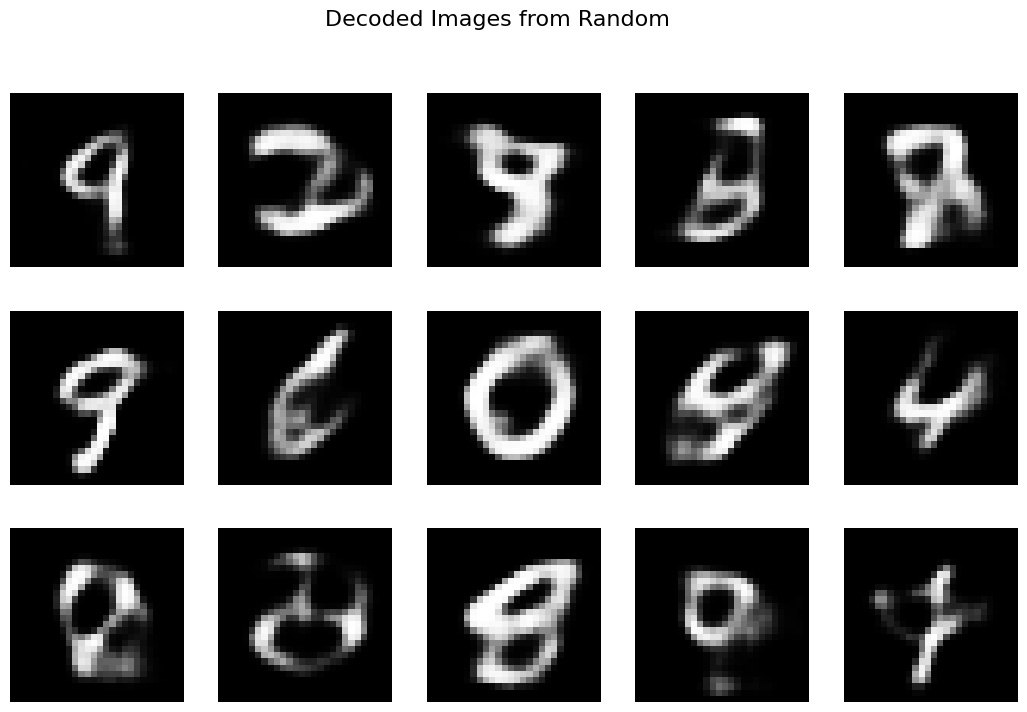

In [ ]:

samples = 15
plt.figure(figsize=(13, 8))
plt.suptitle("Decoded Images from Random", fontsize=16)
for i in range(1, samples + 1):
    encoded_latent = torch.normal(0, 1, size=(1, 50))
    decoded = vae.decode(encoded_latent)

    plt.subplot(3, 5, i)
    plt.imshow(decoded.view(28, 28).detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()
